In [2]:
import numpy as np
from scipy.io import loadmat
from collections import Counter
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from scipy.stats import chisquare
from sklearn.metrics import confusion_matrix, accuracy_score


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

### Verisetine baktığımızda, groundtruth verisi üzerinde oldukça az sayıda sınıflandırılmış piksel var. Bu sebeple herhangi bir skor değeri elde etmemiz pek mümkün değil. Ancak, çeşitli şekillerde modeller eğitip, çıktıları çizdirmek ve daha önce yapılan çalışmalar ile kıyaslamak bize yaptığımızın doğruluğu hakkında fikir verebilir. 
### Groundtruth veriseti içerisinde herhangi bir metadata dosyası yok, ancak toplam 14 farklı sınıflandırma mevcut. _"Spatially Cost-Sensitive Active Learning"_ çalışmasında, bu sınıflandırmalar şu şekilde belirtilmiş:

<html>
<head>
<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

tr:nth-child(even) {
  background-color: #dddddd;
}
</style>
</head>
<body>

<table>
  <tr>
    <th>Class Number</th>
    <th>Class Name</th>
    <th>Class Color</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Unlabeled</td>
    <td>   </td>
  </tr>
  <tr>
    <td>1</td>
    <td>Water</td>
          <td  style="background-color:   #0fecef;">  </td>
  </tr>
  <tr>
    <td>2</td>
    <td>hippo grass</td>
          <td  style="background-color:   #8bfc7b;">  </td>
  </tr>
  <tr>
    <td>3</td>
    <td>floodplain grasses 1</td>
          <td  style="background-color:  #5f3c3e;">  </td>
  </tr>
  <tr>
    <td>4</td>
    <td>floodplain grasses 2</td>
          <td  style="background-color:  #ea1929;">  </td>
  </tr>
  <tr>
    <td>5</td>
    <td>reeds</td>
          <td  style="background-color:   #6d2d70;">  </td>
  </tr>
  <tr>
    <td>6</td>
    <td>riparian</td>
          <td  style="background-color:  #915124;">  </td>
  </tr>
  <tr>
    <td>7</td>
    <td>firescar</td>
          <td  style="background-color:  #366a0a;">  </td>
  </tr>
  <tr>
    <td>8</td>
    <td>island interior</td>
          <td  style="background-color:   #76ac6e;">  </td>
  </tr>
  <tr>
    <td>9</td>
    <td>acacia woodlands</td>
          <td  style="background-color:  #e8e82a;">  </td>
  </tr>
  <tr>
    <td>10</td>
    <td>acacia shrublands</td>
          <td  style="background-color:  #fc73ea;">  </td>
  </tr>
  <tr>
    <td>11</td>
    <td>acacia grasslands</td>
          <td  style="background-color:  #5864a0;">  </td>
  </tr>
  <tr>
    <td>12</td>
    <td>short mopane</td>
          <td  style="background-color:  #f1f6f1;">  </td>
  </tr>
  <tr>
    <td>13</td>
    <td>mixed mopane</td>
          <td  style="background-color:  #f0b175;">  </td>
  </tr>
  <tr>
    <td>14</td>
    <td>exposed soils</td>
          <td  style="background-color:    #69c4a5;">  </td>
  </tr>
</table>
    
    <div style="width: 300px; height: 300px; background-color: #336699">&nbsp;</div>

</body>
</html>


#### Buradan hareketle, ilk iş olarak sınıflandırmaları andıracak şekilde bir renk paleti ayarlayabiliriz.

In [3]:
col_palette = ["#0fecef", "#8bfc7b", "#5f3c3e", "#ea1929", "#6d2d70", "#915124", "#366a0a", "#76ac6e", "#e8e82a", "#fc73ea", "#5864a0", "#f6f1f6", "#f0b175", "#69c4a5"]

In [4]:
my_colors = ListedColormap(sns.color_palette(col_palette))

#### Şimdi verisetini yükleyip, inceleyelim ve veri setini modelleri eğitebilecek şekilde hazırlayalım.

In [5]:
data = loadmat("data/Botswana.mat")["Botswana"]
print(data.shape)
data_gt = loadmat("data/Botswana_gt.mat")["Botswana_gt"]
print(data_gt.shape)

(1476, 256, 145)
(1476, 256)


In [35]:
ct = data_gt.reshape(1476*256)
count = Counter(ct)
print(count)

Counter({0: 374608, 9: 314, 11: 305, 1: 270, 5: 269, 6: 269, 13: 268, 7: 259, 3: 251, 10: 248, 4: 215, 8: 203, 12: 181, 2: 101, 14: 95})


In [36]:
374608/ct.size

0.9914041327913279

#### Görüldüğü üzere, groundtruth verisinin sadece %0,9'luk kısmı sınıflandırılmış ve kalan kısım işimize yaramıyor. Bu sebeple düzgün bir temizlik yaparak işe yarar bir doğrulama verisi elde etmemiz gerekiyor. Aksi halde kullandığımız hiçbir algoritma doğru düzgün bir sonuç vermeyecektir. 

In [37]:
del count[0]

Counter({9: 314, 11: 305, 1: 270, 5: 269, 6: 269, 13: 268, 7: 259, 3: 251, 10: 248, 4: 215, 8: 203, 12: 181, 2: 101, 14: 95})


<BarContainer object of 14 artists>

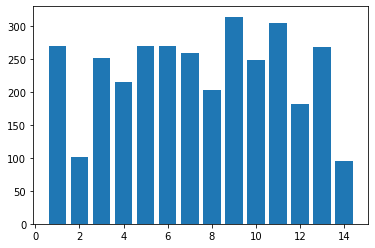

In [38]:
print(count)
plt.bar(count.keys(), count.values())

#### Ancak 0'lardan, yani sınıflandırılmamış piksellerden kurtuduğumuzda, elimizdeki etiketlenmiş verinin oldukça düzgün bir dağılımda olduğu gözüküyor.

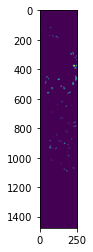

In [39]:
plt.imshow(data_gt, vmax=14, vmin=0)

### Groundtruth datası oldukça kısıtlı, dolayısıyla öncelikle GT datasını mümkün olduğunca anlamlı hale getirebilmek için, bütün satır ya da sutün boyunca "0" değerine sahip satır ve sutünları droplamalıyız. Belki bu sayede biraz daha anlamlı bir veri elde etmek mümkün olabilir. 

#### Groundtruth verisi oldukça kısıtlı bir sınıflandırma içeriyor. Bu haldeyken hangi modeli kullanırsak kullanalım, düzgün bir sonuç almamız mümkün değil. Bu sebepten groundtruth verisini mümkün olduğunca kullanılabilir hale getirmek gerekiyor. Bunun için iki farklı yöntem deneceğim:

#### 1) Bir satırdaki bütün elemanlar veya bir sutündaki bütün elemanlar "0" ise, o satır veya sütunu droplayacağım. Ardıdan kalan satır ve sutünlarla yeni bir matris elde edecek ve bunu yeni groundtruth verisi olarak kullanacağım. Bununla beraber dropladığım satır ve sutünların indexlerini tutup, esas veriden de bunları atacak ve denetimli öğrenme modellerini bu iki veriseti ile eğiteceğim. 

#### 2) Groundtruth verisi üzerinde 0'dan farklı olan bütün değerleri sırasıyla bir vektörün elemanları olarak atayacağım. Aynı zamanda bu veriler matris üzerindeki koordinatına denk gelen indexleri tutacak, ve esas datada ona karşılık gelen pikselin, bütün bant değerlerini alacak ve bir matrise atayacağım. Dolayısıyla 0'hariç diğer değerlerin mevcut olduğu groundtruth verisi ve onlara karşılık gelen piksel verileri ile modelleri eğiteceğim. 

#### Bunun ardından, bütün data üzerinde tahminde bulunacağım.

### 1. METOD

In [40]:
sum_col = data_gt.sum(axis=0)
sum_row = data_gt.sum(axis=1)
print(Counter(sum_col))
print(Counter(sum_row))

##Burada yeni oluşturacağımız GroundTruth datasının boyutunu anlamak için kaç satır ve sutünün sadece 0 içerdiğini öğrendik.
##Dolayısıyla toplam boyuttan buradaki 0 değerlerini çıkararak yeni bir GT matrisi elde edebiliriz. 
## Toplamda 38 sutün tamamen 0 değerinden oluşuyor ve 990 satır sadece 0 değerinden oluşuyor.

Counter({0: 38, 94: 5, 80: 5, 44: 4, 82: 4, 38: 4, 48: 4, 32: 4, 83: 4, 28: 3, 54: 3, 63: 3, 55: 3, 84: 3, 115: 3, 45: 3, 68: 3, 90: 3, 33: 3, 60: 3, 93: 3, 14: 2, 5: 2, 6: 2, 72: 2, 81: 2, 71: 2, 103: 2, 88: 2, 119: 2, 145: 2, 35: 2, 40: 2, 132: 2, 138: 2, 116: 2, 122: 2, 70: 2, 107: 2, 30: 2, 100: 2, 109: 2, 49: 2, 53: 2, 59: 2, 23: 2, 29: 2, 31: 2, 127: 2, 118: 2, 85: 2, 78: 2, 7: 1, 8: 1, 9: 1, 89: 1, 92: 1, 153: 1, 64: 1, 137: 1, 166: 1, 177: 1, 165: 1, 56: 1, 76: 1, 106: 1, 27: 1, 37: 1, 15: 1, 13: 1, 61: 1, 91: 1, 95: 1, 75: 1, 26: 1, 34: 1, 42: 1, 129: 1, 126: 1, 123: 1, 148: 1, 130: 1, 19: 1, 47: 1, 67: 1, 65: 1, 36: 1, 135: 1, 200: 1, 199: 1, 183: 1, 159: 1, 16: 1, 51: 1, 57: 1, 125: 1, 97: 1, 102: 1, 98: 1, 73: 1, 86: 1, 79: 1, 111: 1, 117: 1, 110: 1, 149: 1, 195: 1, 230: 1, 307: 1, 481: 1, 508: 1, 456: 1, 377: 1, 365: 1, 271: 1, 292: 1, 277: 1, 264: 1, 243: 1, 245: 1, 213: 1, 261: 1, 269: 1, 196: 1, 350: 1, 426: 1, 518: 1, 486: 1, 420: 1, 432: 1, 398: 1, 376: 1, 332: 1, 298

In [41]:
df_GT = pd.DataFrame(data_gt)
df_GT

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1472,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1474,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
df_GT = df_GT.loc[:, (df_GT != 0).any(axis=0)]
df_GT = df_GT.loc[(df_GT != 0).any(axis=1), :]
df_GT

,18,19,20,21,22,23,24,25,34,35,...,243,244,245,246,247,248,249,250,251,252
118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139,0,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140,14,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1091,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
new_gt = np.array(df_GT)
new_gt

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [45]:
print(Counter(new_gt.reshape(486*218)))
print(102700/(486*218)) ##0'lar/Toplam elemanaların sayısı

###Buradan gözüktüğü üzere, 0 hariç diğer labelların sayısı ilk baştaki ile aynı duruyor, anlamlı hiçbir sutünü kaybetmemişiz.
### Ancak hala çok fazla 0 mevcut. Dolayısıyla anlamlı bir şeyler elde etmek hala çok mümkün gözükmüyor. 

Counter({0: 102700, 9: 314, 11: 305, 1: 270, 5: 269, 6: 269, 13: 268, 7: 259, 3: 251, 10: 248, 4: 215, 8: 203, 12: 181, 2: 101, 14: 95})
0.9693434515045116


<ipython-input-46-acffc47b8ad1>:4: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))



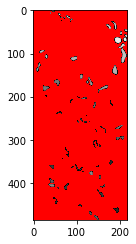

In [46]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
cmap = cm.get_cmap('gray')
cmap.set_under('red')
plt.imshow(df_GT, cmap=cmap, vmax=14, vmin=1)

#### Hala çok düzgün bir GroundTruth datası elde edemedik. Piksellerin %96sından fazlası hala anlamsız bir sınıflandırma içeriyor. Bu şekilde bir sonuç elde etmek pek mümkün gözükmüyor. Ancak yine de esas verisetindeki değerleri de bu düzeye getirelim. Bunun için groundtruth datasında hangi satır ve sutünları bırakıp, hangilerini tuttuğumuzu bulup, bunu esas verisetimize de uygulamamız gerekiyor. 

In [47]:
rows_numbers = list(Counter(df_GT.T).keys())
cols_numbers = list(Counter(df_GT).keys())

In [48]:
data.shape

(1476, 256, 145)

In [49]:
del_rows = list(np.arange(0,1476,1))
for x in rows_numbers:
    del_rows.remove(x)

    
del_cols = list(np.arange(0,256,1))
for y in cols_numbers:
    del_cols.remove(y)

In [50]:
data_cl = np.delete(data, del_rows, axis=0)
data_cl = np.delete(data_cl, del_cols, axis=1)
print(data_cl.shape)

(486, 218, 145)


In [51]:
np.savetxt("new_gt.txt", new_gt.reshape(486*218), delimiter=',')
np.savetxt("new_data.txt", data_cl.reshape(486*218,145), delimiter=',')

### <font color ="red"> Bundan sonrasını UHEM üzerinden yaptım. Buraya sadece UHEM üzerinden ayrı scriptler olarak yazıp, çıktılarını aldığım kodları yazacağım. </font>

In [10]:
x = np.loadtxt("data/new_data.txt", delimiter=",")
gt = np.loadtxt("data/new_gt.txt", delimiter=",")
data = data.reshape(1476*256,145)

### LOGISTIC REGRESSION

#### LBFGS

In [ ]:
model = LogisticRegression(C = 10000,
                            tol = 1e-4,
                            penalty = "l2",
                            solver = "lbfgs",
                            multi_class = "ovr",
                            max_iter = 100000,
                            n_jobs = -1)

model.fit(x, gt)
predicted = model.predict(data)
predict = predicted.reshape(1,predicted.size)

#### NEWTON-CG

In [ ]:
model = LogisticRegression(C = 10000,
                            tol = 1e-4,
                            penalty = "l2",
                            solver = "newton-cg",
                            multi_class = "ovr",
                            max_iter = 100000,
                            n_jobs = -1)

model.fit(x, gt)
predicted = model.predict(data)
predict = predicted.reshape(1,predicted.size)

#### SAG

In [ ]:
model = LogisticRegression(C = 10000,
                            tol = 1e-4,
                            penalty = "l2",
                            solver = "sag",
                            multi_class = "ovr",
                            max_iter = 100000,
                            n_jobs = -1)

model.fit(x, gt)
predicted = model.predict(data)

### SVM

#### RBF

In [ ]:
model = SVC(C=10000,
             kernel='rbf',
             max_iter=50000)




model.fit(x2, gt2)
predicted = model.predict(data)
predict = predicted.reshape(1,predicted.size)

#### LINEAR

In [ ]:
model = SVC(C=10000,
             kernel='linear',
             max_iter=50000)




model.fit(x2, gt2)
predicted = model.predict(data)

### KNN

In [ ]:
modelKNN = KNeighborsClassifier(n_neighbors=15, n_jobs = -1)
modelKNN.fit(x2,gt2)
predictedKNN = modelKNN.predict(data)
predict = predictedKNN.reshape(1, predictedKNN.size)

### KMEANS

In [ ]:
kmeans = KMeans(n_clusters=14, max_iter=100000)
predictedkmeans = kmeans.fit_predict(data)
predict = predictedkmeans.reshape(1,predictedkmeans.size)

### LDA

In [11]:

modelLDA1 = LDA(n_components=13)

modelLDA1.fit(x, gt)

LinearDiscriminantAnalysis(n_components=13)

In [16]:
LDA1 = modelLDA1.predict(data)
LDA1 = LDA1.reshape(1476,256)
LR_lbfgs1 = np.loadtxt("LogisticRegression/LRlbfgs1.txt").reshape(1476,256)
LR_ng1 = np.loadtxt("LogisticRegression/LRng1.txt").reshape(1476,256)
LR_sag1 = np.loadtxt("LogisticRegression/LRsag1.txt").reshape(1476,256)
SVM_linear1 = np.loadtxt("SVM/SVMLinear1.txt").reshape(1476,256)
SVM_rbf1 = np.loadtxt("SVM/SVMRbf1.txt").reshape(1476,256)
KMEANS = np.loadtxt("KMEANS/Kmeansdata.txt").reshape(1476,256)
KNN1 = np.loadtxt("KNN/KNNresults1.txt").reshape(1476,256)

<Figure size 800x800 with 0 Axes>

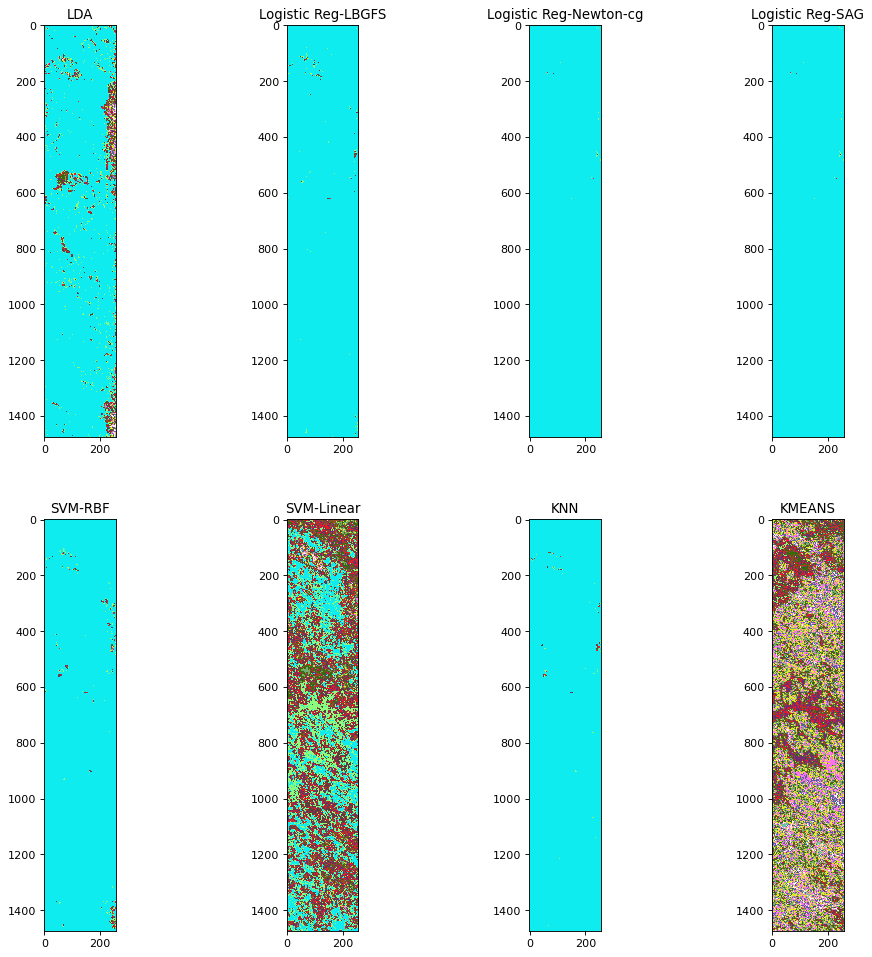

In [17]:
### KMEANS ALGORİTMASI RENK OLARAK DİĞERLERİNDEN FARKLI OLACAK.

plt.figure(figsize=(10, 10), dpi=80)
f, axarr = plt.subplots(2,4, figsize=(15,15), dpi=80) 

axarr[0][0].imshow(LDA1, cmap = my_colors)
axarr[0][0].title.set_text("LDA")
axarr[0][1].imshow(LR_lbfgs1, cmap = my_colors)
axarr[0][1].title.set_text("Logistic Reg-LBGFS")
axarr[0][2].imshow(LR_ng1, cmap = my_colors)
axarr[0][2].title.set_text("Logistic Reg-Newton-cg")
axarr[0][3].imshow(LR_sag1, cmap = my_colors)
axarr[0][3].title.set_text("Logistic Reg-SAG")
axarr[1][0].imshow(SVM_rbf1, cmap = my_colors)
axarr[1][0].title.set_text("SVM-RBF")
axarr[1][1].imshow(SVM_linear1, cmap = my_colors)
axarr[1][1].title.set_text("SVM-Linear")
axarr[1][2].imshow(KNN1, cmap = my_colors)
axarr[1][2].title.set_text("KNN")
axarr[1][3].imshow(KMEANS, cmap = my_colors)
axarr[1][3].title.set_text("KMEANS")

plt.savefig('my_plot.png')

### 2. Metod

In [52]:
arr_gt = np.array([])
arr = np.array([])

for i in range(486):
    for j in range(218):
        if int(new_gt[i,j]) != 0:
            arr_gt = np.append(arr_gt, new_gt[i,j])
            arr = np.append(arr, data_cl[i][j])

In [53]:
print(data_cl.shape)
print(new_gt.shape)

(486, 218, 145)
(486, 218)


In [54]:
print(arr_gt.shape)
print(arr.shape)

(3248,)
(470960,)


In [57]:
arr = arr.reshape(3248,145)
print(np.unique(arr_gt))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


In [58]:
np.savetxt("arr_gt.txt", arr_gt, delimiter=',')
np.savetxt("arr_data.txt", arr, delimiter=',')

#### <font color="red">Bu aşamadan sonra UHEM üzerinden hesaplama yapıldı ve çıktılar alındı.</font>

In [6]:
x2 = np.loadtxt("data/arr_data.txt", delimiter=",")
gt2 = np.loadtxt("data/arr_gt.txt", delimiter=",")
data = data.reshape(1476*256,145)

### LOGISTIC REGRESSION

#### LBFGS

In [ ]:
model = LogisticRegression(C = 10000,
                            tol = 1e-4,
                            penalty = "l2",
                            solver = "lbfgs",
                            multi_class = "ovr",
                            max_iter = 100000,
                            n_jobs = -1)

model.fit(x2, gt2)
predicted = model.predict(data)
predict = predicted.reshape(1,predicted.size)

#### NEWTON-CG

In [ ]:
model = LogisticRegression(C = 10000,
                            tol = 1e-4,
                            penalty = "l2",
                            solver = "newton-cg",
                            multi_class = "ovr",
                            max_iter = 100000,
                            n_jobs = -1)

model.fit(x2, gt2)
predicted = model.predict(data)
predict = predicted.reshape(1,predicted.size)

#### SAG

In [ ]:
model = LogisticRegression(C = 10000,
                            tol = 1e-4,
                            penalty = "l2",
                            solver = "sag",
                            multi_class = "ovr",
                            max_iter = 100000,
                            n_jobs = -1)

model.fit(x2, gt2)
predicted = model.predict(data)
predict = predicted.reshape(1,predicted.size)

### SVM

#### RBF

In [ ]:
model = SVC(C=10000,
             kernel='rbf',
             max_iter=50000)




model.fit(x2, gt2)
predicted = model.predict(data)
predict = predicted.reshape(1,predicted.size)

#### LINEER

In [ ]:
model = SVC(C=10000,
             kernel='linear',
             max_iter=50000)




model.fit(x2, gt2)
predicted = model.predict(data)
predict = predicted.reshape(1,predicted.size)

### KNN

In [ ]:
modelKNN = KNeighborsClassifier(n_neighbors=15, n_jobs = -1)
modelKNN.fit(x2,gt2)
predictedKNN = modelKNN.predict(data)
predict = predictedKNN.reshape(1, predictedKNN.size)

### KMEANS

In [ ]:
kmeans = KMeans(n_clusters=14, max_iter=100000)
predictedkmeans = kmeans.fit_predict(data)
predict = predictedkmeans.reshape(1,predictedkmeans.size)

### LDA

In [7]:
modelLDA2 = LDA(n_components=13)

modelLDA2.fit(x2, gt2)

LinearDiscriminantAnalysis(n_components=13)

#### Şimdi modeller tarafından tahmin edilen dataları yükleyip, çizdirelim.

In [8]:
LDA2 = modelLDA2.predict(data)
LDA2 = LDA2.reshape(1476,256)
LR_lbfgs2 = np.loadtxt("LogisticRegression/LRlb.txt").reshape(1476,256)
LR_ng2 = np.loadtxt("LogisticRegression/LRng.txt").reshape(1476,256)
LR_sag2 = np.loadtxt("LogisticRegression/LRsag.txt").reshape(1476,256)
SVM_linear2 = np.loadtxt("SVM/SVMLinear.txt").reshape(1476,256)
SVM_rbf2 = np.loadtxt("SVM/SVMRbf.txt").reshape(1476,256)
KMEANS = np.loadtxt("KMEANS/Kmeansdata.txt").reshape(1476,256)
KNN2 = np.loadtxt("KNN/KNNresults.txt").reshape(1476,256)

<Figure size 800x800 with 0 Axes>

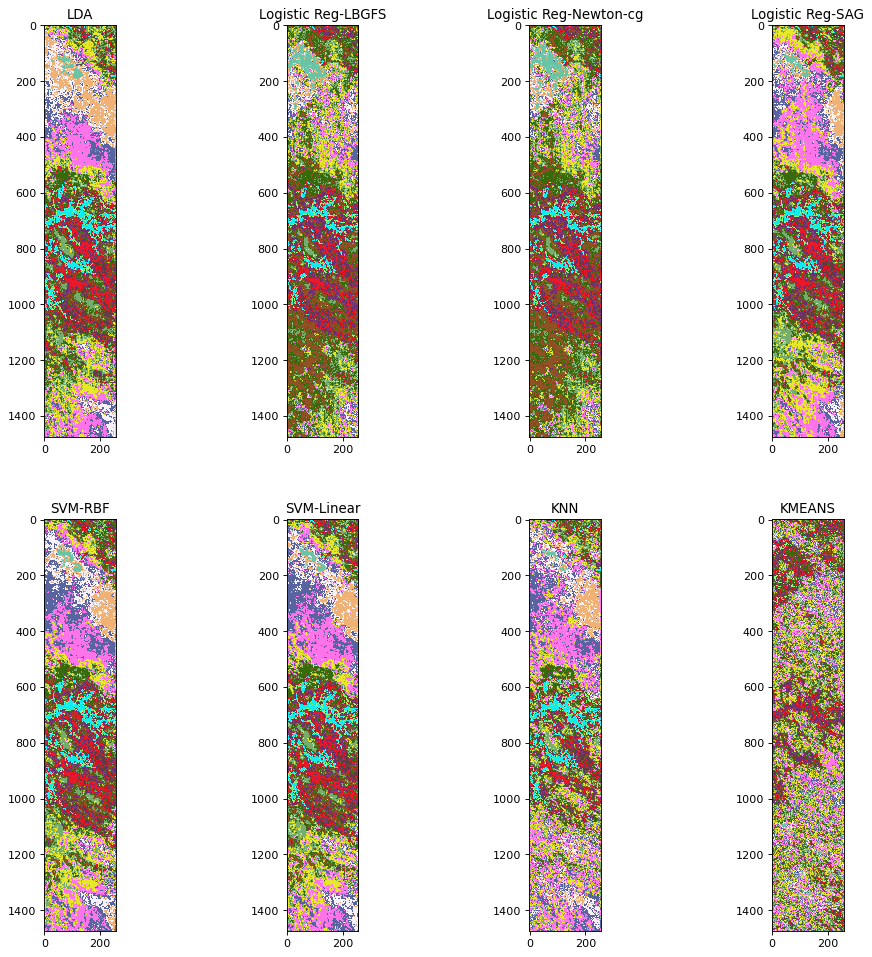

In [9]:
### KMEANS ALGORİTMASI RENK OLARAK DİĞERLERİNDEN FARKLI OLACAK.

plt.figure(figsize=(10, 10), dpi=80)
f, axarr = plt.subplots(2,4, figsize=(15,15), dpi=80) 

axarr[0][0].imshow(LDA2, cmap = my_colors)
axarr[0][0].title.set_text("LDA")
axarr[0][1].imshow(LR_lbfgs2, cmap = my_colors)
axarr[0][1].title.set_text("Logistic Reg-LBGFS")
axarr[0][2].imshow(LR_ng2, cmap = my_colors)
axarr[0][2].title.set_text("Logistic Reg-Newton-cg")
axarr[0][3].imshow(LR_sag2, cmap = my_colors)
axarr[0][3].title.set_text("Logistic Reg-SAG")
axarr[1][0].imshow(SVM_rbf2, cmap = my_colors)
axarr[1][0].title.set_text("SVM-RBF")
axarr[1][1].imshow(SVM_linear2, cmap = my_colors)
axarr[1][1].title.set_text("SVM-Linear")
axarr[1][2].imshow(KNN2, cmap = my_colors)
axarr[1][2].title.set_text("KNN")
axarr[1][3].imshow(KMEANS, cmap = my_colors)
axarr[1][3].title.set_text("KMEANS")

plt.savefig('my_plot2.png')

####  Görüldüğü üzere, KMeans hariç bütün algoritmalar oldukça benzer değerler verdiler. Su olan arazileri neredeyse hepsi benzer şekilde tahmin etti. Bu zaten suyun rengi ve yansıtıcılığı diğer renklere göre daha farklı olduğu için, tahmin edilen bir sonuçtu. 

#### Şimdi son olarak şunu deneyeceğim: Bütün supervised metodların tahmin edilen değerlerinin sonuçlarını beraber görselleştireceğim.

In [50]:
sum2 = ((SVM_linear2 + SVM_rbf2 + LR_lbfgs2 + LR_ng2 + LR_sag2 + LDA2 + KNN2)/7).round()

Text(0.5, 1.0, 'Sum of all models')

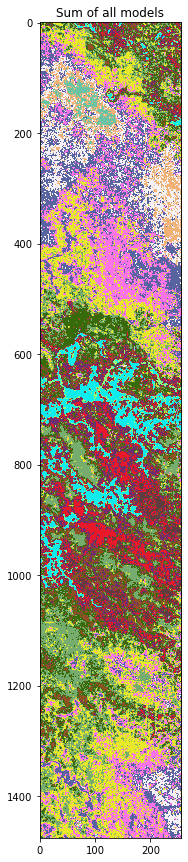

In [51]:
plt.figure(figsize = (15,15))
plt.imshow(sum2, cmap = my_colors)
plt.title("Sum of all models")